In [18]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [42]:
DATASET_PATH = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

In [43]:
def extract_label(filename):
    if '_B_' in filename:
        return 0
    elif '_M_' in filename:
        return 1
    return -1

In [44]:
def load_data(dataset_path):
    image_paths = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                label = extract_label(file)
                if label != -1:
                    image_paths.append(os.path.join(root, file))
                    labels.append(label)
    return np.array(image_paths), np.array(labels)

image_paths, labels = load_data(DATASET_PATH)

In [45]:
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, random_state=42, stratify=train_val_labels
)

print(f"Training size: {len(train_paths)}")
print(f"Validation size: {len(val_paths)}")
print(f"Test size: {len(test_paths)}")

Training size: 5694
Validation size: 1424
Test size: 791


In [47]:
# === One-hot Encode Labels ===
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
train_labels_cat = to_categorical(train_labels, num_classes=2)
val_labels_cat = to_categorical(val_labels, num_classes=2)
test_labels_cat = to_categorical(test_labels, num_classes=2)

In [48]:

# === Preprocessing Function ===
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img, label


In [49]:
# === TF Datasets ===
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels_cat))
    .shuffle(len(train_paths))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels_cat))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels_cat))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

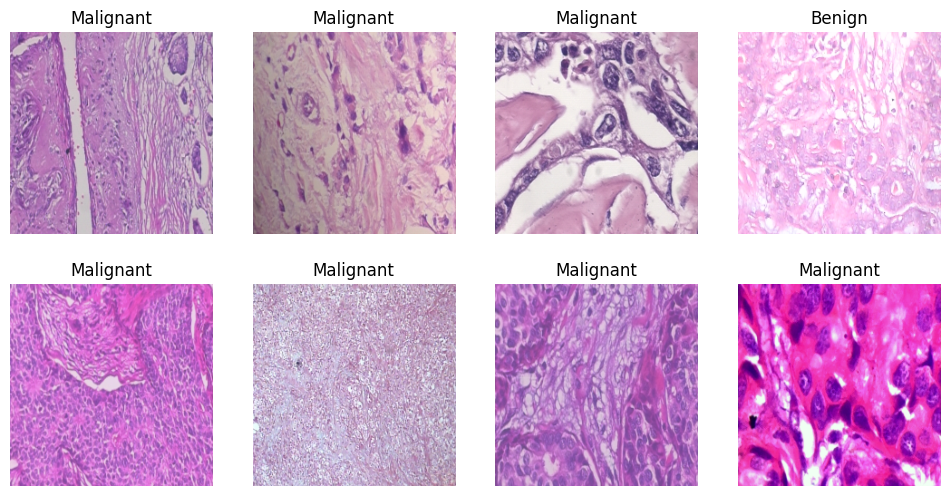

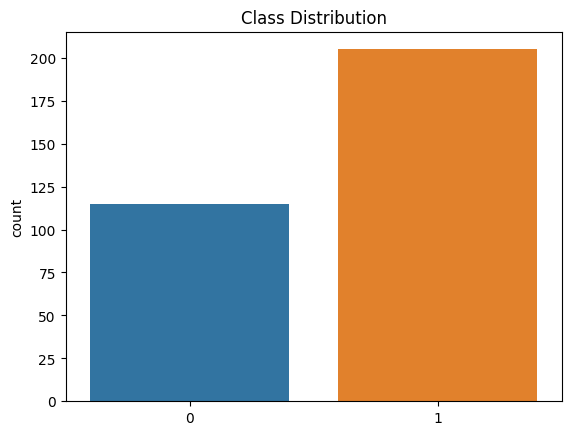

In [50]:
# === Visualize Samples ===
plt.figure(figsize=(12, 6))
for images, labels in train_dataset.take(1):
    images = tf.clip_by_value(images, 0.0, 1.0)
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title('Malignant' if tf.argmax(labels[i]) == 1 else 'Benign')
        plt.axis("off")
plt.show()

# === Label Distribution ===
labels_array = np.argmax(np.concatenate([y.numpy() for _, y in train_dataset.take(10)]), axis=1)
sns.countplot(x=labels_array)
plt.title('Class Distribution')
plt.show()

In [51]:
# === Model Definition ===
def create_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Softmax for 2-class one-hot
    ])
    return model

model = create_model()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,245,186 (84.86 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# === Optimizer, Loss, Metrics ===
optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [53]:
# === Class Weights ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = {i: float(class_weights[i]) for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 1.5949579831932774, 1: 0.72831926323868}


In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# === Callbacks ===
def train_model(model, model_name):
    checkpoint = ModelCheckpoint(f"{model_name}_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    
    return [checkpoint, reduce_lr, early_stop]

In [55]:

# === Train Model ===
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    class_weight=class_weight_dict,
    callbacks=train_model(model, "histopathology_softmax")
)

Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6634 - loss: 0.6547
Epoch 1: val_loss improved from inf to 0.52538, saving model to histopathology_softmax_best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 171ms/step - accuracy: 0.6638 - loss: 0.6542 - val_accuracy: 0.7823 - val_loss: 0.5254 - learning_rate: 1.0000e-04
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8060 - loss: 0.5067
Epoch 2: val_loss improved from 0.52538 to 0.45748, saving model to histopathology_softmax_best_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - accuracy: 0.8061 - loss: 0.5066 - val_accuracy: 0.8413 - val_loss: 0.4575 - learning_rate: 1.0000e-04
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8364 - loss: 0.4713
Epoch 3: val_loss did not improve from 0.45748
178/178 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.8364 - loss: 0.4713 - val_accuracy: 0.8174 - val_loss: 0.4901 - learning_rate: 1.0000e-04
Epoch 4/40
178/178 ━━━━━━━━━━━━━━

In [56]:
# === Evaluate on Test Set ===
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.8890 - loss: 0.3235

Test Accuracy: 86.98%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step

Classification Report:
              precision 

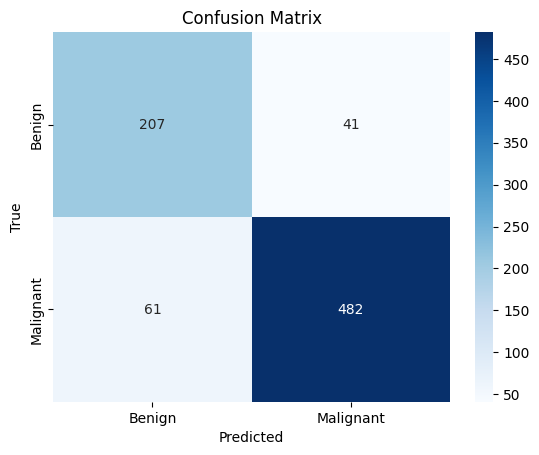

In [57]:
# === Classification Report ===
y_true = np.argmax(test_labels_cat, axis=1)
y_pred = []

for images, _ in test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

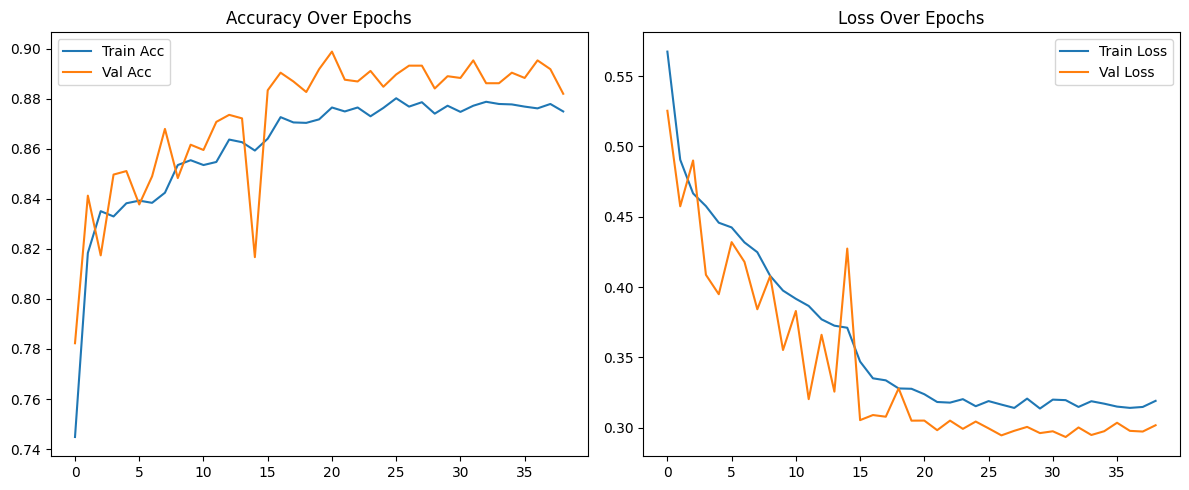

In [58]:
# === Accuracy & Loss Plots ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
# === Save Final Model in HDF5 Format (.h5) ===
model.save("histopathology_breast_cancer_model.h5")
print("Model saved as histopathology_breast_cancer_model.h5")


Model saved as histopathology_breast_cancer_model.h5
